In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.tsatools import lagmat

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV

data = pd.read_csv("updated_data.csv")
data.Date = data.Date.apply(lambda x: pd.to_datetime(x))

#'TCS', 'HCLTECH', 'INFY'

# ticker1 = "NDAQ-US"
# ticker2 = "ICE-US"
# ticker3 = "CME-US"

ticker1 = "TCS"
ticker2 = "HCLTECH"
ticker3 = "INFY"

data = data.sort_values("Date").reset_index().drop("index", axis=1)
data = data[["Date", ticker1, ticker2, ticker3]]
#data["spread"] = data[ticker1] - data[ticker2]

#data = data[["Date", "spread"]]
data.index = data.Date

In [ ]:
ticker = ticker3

In [ ]:
stock1 = data[[ticker]].rename(columns={ticker: "price"})

In [ ]:
def get_stock_ret(data):
    res = data.copy()
    res["ret"] = data.diff(1)
    res["ret_direction"] = data.diff(1).diff(1)
    return res

def diff_creation(data):
    df = data.copy()
    df["delta_ret"] = np.nan
    #df.loc[1:, "diff"] = (df.iloc[1:, 1].as_matrix() - df.iloc[:len(df)-1, 1].as_matrix())
    df.loc[1:, "delta_ret"] = df.ret.diff(1)
    return df

def lag_func(data, lag):
    lag = lag
    X = lagmat(data["delta_ret"], lag)
    lagged = data.copy()
    for c in range(1,lag+1):
        lagged["lag%d" % c] = X[:, c-1]
    return lagged

def train_test(data_lag, lag):
    xc = ["lag%d" % i for i in range(1,lag+1)]
    split = 0.70
    xt = data_lag[(lag+1):][xc]
    yt = (data_lag[(lag+1):]["delta_ret"] >= 0).apply(lambda x: int(x))
    date = data_lag["Date"]
    isplit = int(len(xt) * split)
    x_train, y_train, x_test, y_test = xt[:isplit], yt[:isplit], xt[isplit:], yt[isplit:]
    date_train, date_test = date[:isplit], date[isplit:]
    return x_train, y_train, x_test, y_test, xt, yt, date_train, date_test

In [ ]:
temp = get_stock_ret(stock1)
temp = diff_creation(temp)
temp.ret_direction = (temp.ret_direction > 0).apply(lambda x: int(x))

/var/folders/48/_491cgt57ybcw1cvqxpkj_300000gn/T/ipykernel_26681/1344325444.py:11: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[1:, "delta_ret"] = df.ret.diff(1)


In [ ]:
temp = lag_func(temp, 7).reset_index()
temp.dropna(inplace=True)

In [ ]:
x_train, y_train, x_test, y_test, xt, yt, date_train, date_test = train_test(temp, 7)

### Random Forest Classifier

In [ ]:
param_grid = {'n_estimators': [100, 200, 300],
              'criterion': ['gini', 'entropy'],
              'max_depth': [2, 3, 4]}
rf = GridSearchCV(RandomForestClassifier(), param_grid, cv=10)

#rf = RandomForestClassifier(n_estimators=200, max_depth=2)
rf.fit(x_train, y_train)
print(rf.best_estimator_)
rf = rf.best_estimator_
print("score on train:", rf.score(x_train, y_train))
print("score on test:", rf.score(x_test, y_test))

RandomForestClassifier(criterion='entropy', max_depth=2)
score on train: 0.7103694874851013
score on test: 0.6138888888888889


accuracy score:  0.6138888888888889
              precision    recall  f1-score   support

           0       0.61      0.61      0.61       178
           1       0.62      0.62      0.62       182

    accuracy                           0.61       360
   macro avg       0.61      0.61      0.61       360
weighted avg       0.61      0.61      0.61       360



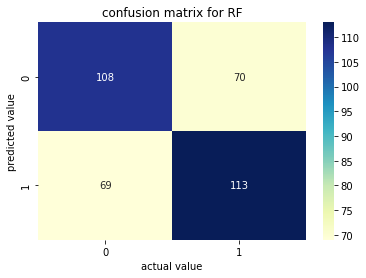

<Figure size 432x288 with 0 Axes>

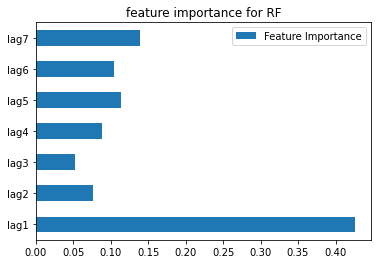

In [ ]:
model = rf
y_pred = model.predict(x_test)

print("accuracy score: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

plt.figure()
sns.heatmap(confusion_matrix(y_test, y_pred), cmap="YlGnBu",fmt=".0f", annot=True)
plt.xlabel("actual value")
plt.ylabel("predicted value")
plt.title("confusion matrix for RF")
plt.savefig("./plots/RF_cmatrix")

plt.figure()
pd.DataFrame({'Feature Importance':model.feature_importances_},
            index=x_test.columns).plot(kind='barh')
plt.title("feature importance for RF")
plt.savefig("./plots/RF_f_importance")

### Gradient Boosting Classifier

In [ ]:
param_grid = {'n_estimators': [50, 150, 300],
              'subsample': [0.5, 0.6, 0.7],
              'max_depth': [2, 3, 4]}
gbc = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=10)
#gbc = GradientBoostingClassifier(n_estimators=100, subsample=0.6, min_samples_leaf=2)
gbc.fit(x_train, y_train)
gbc = gbc.best_estimator_
print(gbc)
print("score on train:", gbc.score(x_train, y_train))
print("score on test:", gbc.score(x_test, y_test))

GradientBoostingClassifier(max_depth=2, n_estimators=50, subsample=0.7)
score on train: 0.7508939213349225
score on test: 0.6694444444444444


              precision    recall  f1-score   support

           0       0.68      0.62      0.65       178
           1       0.66      0.72      0.69       182

    accuracy                           0.67       360
   macro avg       0.67      0.67      0.67       360
weighted avg       0.67      0.67      0.67       360



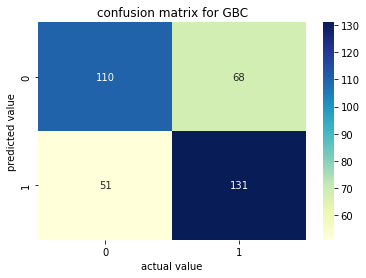

<Figure size 432x288 with 0 Axes>

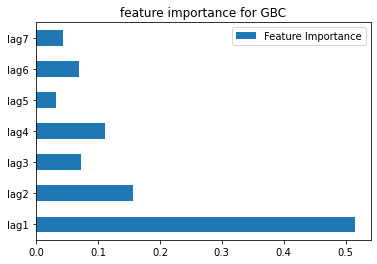

In [ ]:
model = gbc
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

plt.figure()
sns.heatmap(confusion_matrix(y_test, y_pred), cmap="YlGnBu",fmt=".0f", annot=True)
plt.xlabel("actual value")
plt.ylabel("predicted value")
plt.title("confusion matrix for GBC")
plt.savefig("./plots/GBM_cmatrix")

plt.figure()
pd.DataFrame({'Feature Importance':model.feature_importances_},
            index=x_test.columns).plot(kind='barh')
plt.title("feature importance for GBC")
plt.savefig("./plots/GBM_f_importance")

### Logistic Regression

In [ ]:
param_grid = {"solver": ["lbfgs", "liblinear"],
              "fit_intercept": [True, False],
              "C": [0.7, 0.8, 0.9, 1]}
lg = GridSearchCV(LogisticRegression(), param_grid, cv=10)
lg.fit(x_train, y_train)
lg = lg.best_estimator_
print(lg)
print("score on train:", lg.score(x_train, y_train))
print("score on test:", lg.score(x_test, y_test))

LogisticRegression(C=0.7, fit_intercept=False)
score on train: 0.735399284862932
score on test: 0.7361111111111112


              precision    recall  f1-score   support

           0       0.74      0.72      0.73       178
           1       0.74      0.75      0.74       182

    accuracy                           0.74       360
   macro avg       0.74      0.74      0.74       360
weighted avg       0.74      0.74      0.74       360



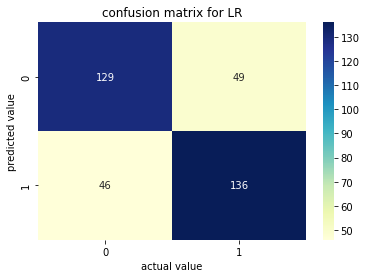

In [ ]:
model = lg
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

plt.figure()
sns.heatmap(confusion_matrix(y_test, y_pred), cmap="YlGnBu",fmt=".0f", annot=True)
plt.xlabel("actual value")
plt.ylabel("predicted value")
plt.title("confusion matrix for LR")
plt.savefig("./plots/LR_cmatrix")

# plt.figure()
# pd.DataFrame({'Feature Importance':model.feature_importances_},
#             index=x_test.columns).plot(kind='barh')
# plt.title("feature importance for LR")
# plt.savefig("./plots/LR_f_importance")